In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_smear_225.h5", "MC/hits")


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,11300,-1442.772095,-482.059631,5283.557129,0.000075
1,11300,-1444.964355,-483.240204,5283.627441,0.001375
2,11300,-1440.086426,-480.735413,5283.657715,0.003825
3,11300,-1434.636597,-478.883301,5283.843750,0.001150
4,11300,-1449.957031,-486.046478,5283.895020,0.002300
...,...,...,...,...,...
27329,11326,-827.042603,-1937.431641,4143.975586,0.000300
27330,11326,-840.641418,-1931.412476,4144.221191,0.001300
27331,11326,-837.630249,-1932.569580,4144.608398,0.000075
27332,11326,-830.652161,-1935.606934,4144.857910,0.006875


,event_id,x,y,z,energy
0,11304,-1981.297607,-851.304077,5036.713379,0.002775
1,11304,-1979.263794,-850.821411,5037.830078,0.002125
2,11304,-1984.635376,-849.883240,5034.627930,0.001925
3,11304,-1976.940308,-848.524963,5038.881836,0.000650
4,11304,-1987.826538,-848.154114,5032.680176,0.000425
...,...,...,...,...,...
930,11304,-1730.762573,-92.407806,5257.688965,0.000125
931,11304,-1722.044800,-92.402756,5250.050781,0.000375
932,11304,-1723.936646,-92.201157,5251.496582,0.000375
933,11304,-1728.761841,-92.080338,5255.404785,0.001375


Median distance to the closest row: 2.545058988337978


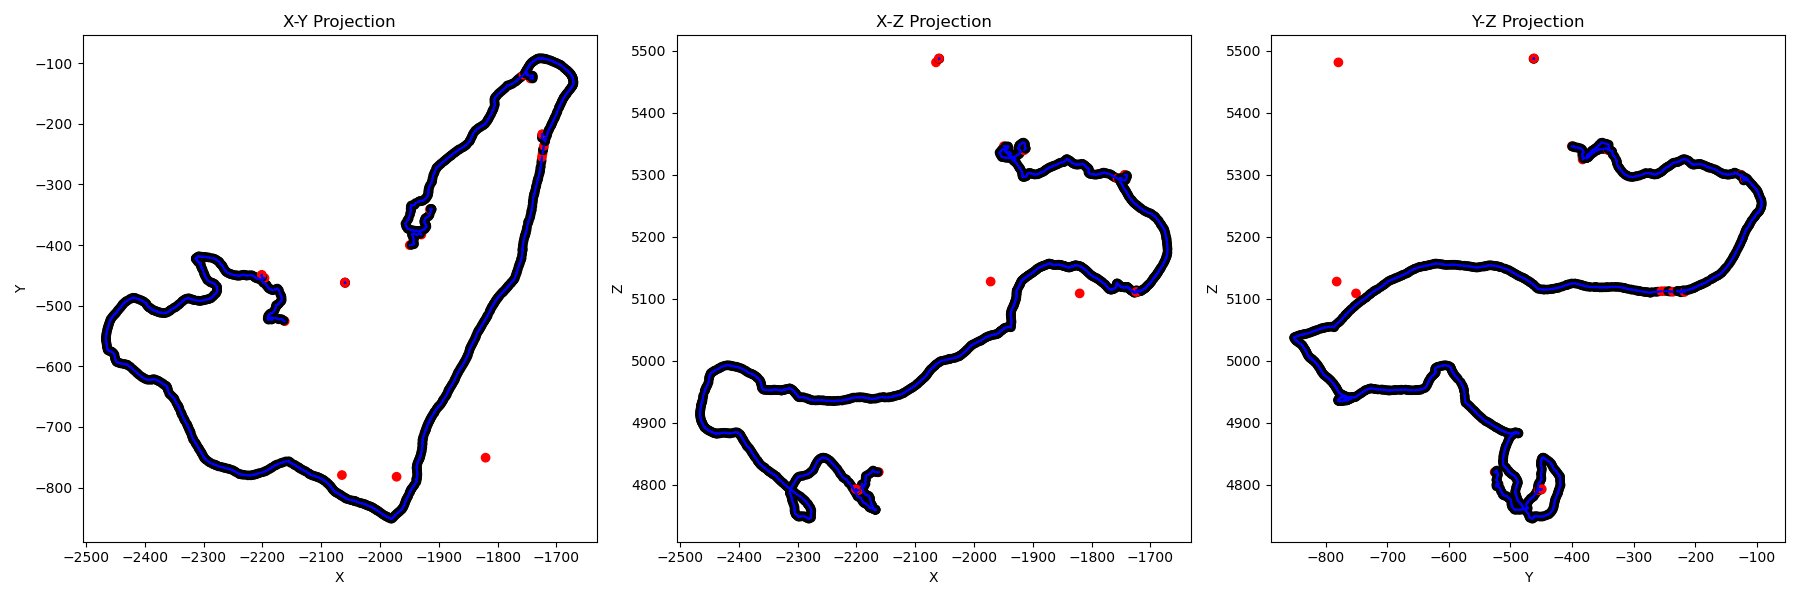

In [15]:
%matplotlib widget

data = hits[hits.event_id ==11304]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['y', "z", "x"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Mean_dist = GetMeanNodeDistances(data) # Mean distance between nodes
init_dist_thresh = Mean_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Mean_dist*5, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 345, 'end': 757, 'nodes': [345, 348, 356, 357, 354, 361, 366, 365, 364, 358, 351, 353, 360, 368, 363, 352, 350, 362, 369, 373, 374, 377, 379, 380, 388, 394, 405, 412, 416, 421, 425, 428, 430, 434, 439, 445, 457, 476, 479, 483, 491, 498, 500, 497, 495, 492, 494, 499, 501, 504, 510, 511, 513, 518, 521, 526, 529, 531, 533, 534, 536, 539, 541, 542, 547, 555, 554, 548, 551, 556, 560, 558, 552, 544, 545, 549, 553, 557, 562, 563, 564, 567, 569, 570, 573, 576, 579, 580, 583, 585, 590, 593, 595, 598, 600, 604, 607, 608, 611, 610, 612, 613, 614, 615, 609, 605, 603, 602, 599, 597, 594, 592, 591, 589, 588, 587, 584, 581, 578, 575, 574, 571, 566, 561, 543, 532, 528, 525, 522, 520, 515, 514, 508, 506, 505, 502, 493, 490, 486, 485, 482, 481, 478, 473, 472, 465, 462, 458, 455, 451, 447, 446, 448, 454, 456, 460, 467, 469, 466, 461, 453, 444, 442, 435, 426, 424, 420, 415, 411, 409, 403, 399, 397, 390, 386, 383, 382, 381, 385, 387, 389, 391, 392, 395, 398, 400, 402, 406, 407, 413, 414,

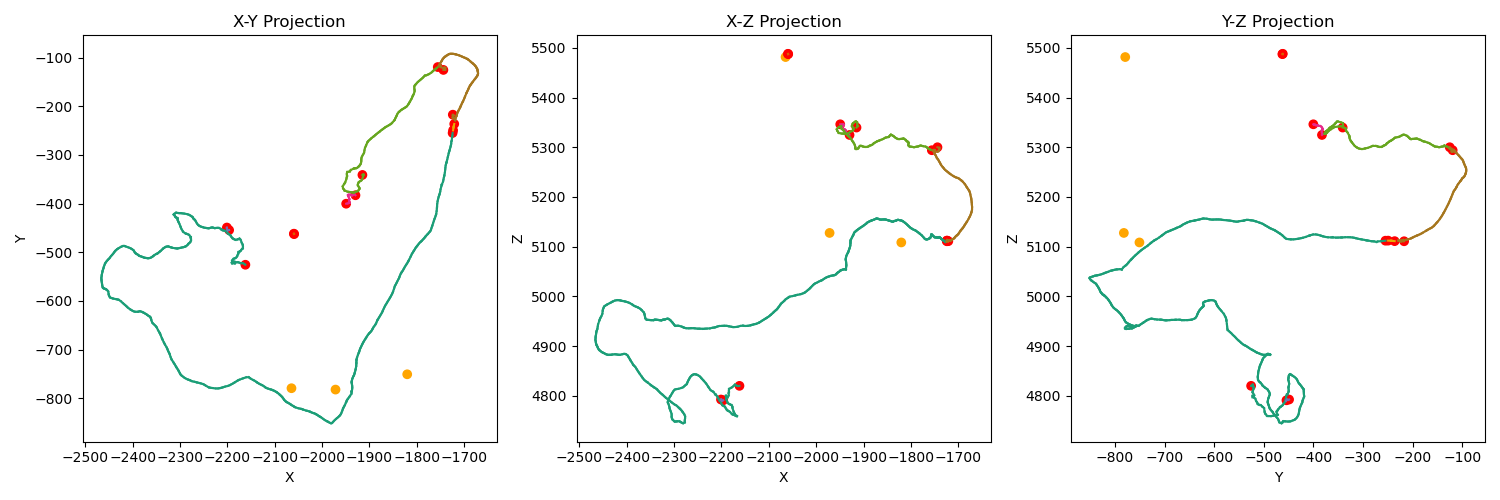

In [16]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [17]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.271
Dist Thresh 13.084


In [18]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [19]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
Loop:  3
True
Total Tracks: 9
{'id': 1, 'start': 517, 'end': 524, 'nodes': [517, 523, 524], 'length': 1.568, 'energy': 0.0651749987155199, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 3, 'start': 538, 'end': 559, 'nodes': [529, 538, 535, 540, 546, 559], 'length': 10.615, 'energy': 0.06972499983385205, 'label': 'track', 'c': 'black'}
{'id': 5, 'start': 622, 'end': 638, 'nodes': [622, 623, 624, 625, 627, 629, 630, 632, 634, 639, 642, 641, 636, 635, 637, 643, 644, 638, 646], 'length': 50.845, 'energy': 0.13724999857367948, 'label': 'track', 'c': 'black'}
{'id': 12, 'start': 82, 'end': 82, 'nodes': [82], 'length': 0, 'energy': 0.002050000010058284, 'label': 'gamma', 'c': 'y'}
{'id': 13, 'start': 89, 'end': 89, 'nodes': [89], 'length': 0, 'energy': 0.02979999966919422, 'label': 'gamma', 'c': 'y'}
{'id': 14, 'start': 158, 'end': 158, 'nodes': [158], 'length': 0, 'energy': 0.027425000444054604, 'label': 'gamma', 'c': 

{'id': 0, 'start': 345, 'end': 690, 'length': 2550.886, 'energy': 1.9223500066837005, 'label': 'Primary', 'c': 'Teal', 'nodes': [345, 348, 356, 357, 354, 361, 366, 365, 364, 358, 351, 353, 360, 368, 363, 352, 350, 362, 369, 373, 374, 377, 379, 380, 388, 394, 405, 412, 416, 421, 425, 428, 430, 434, 439, 445, 457, 476, 479, 483, 491, 498, 500, 497, 495, 492, 494, 499, 501, 504, 510, 511, 513, 518, 521, 526, 529, 531, 533, 534, 536, 539, 541, 542, 547, 555, 554, 548, 551, 556, 560, 558, 552, 544, 545, 549, 553, 557, 562, 563, 564, 567, 569, 570, 573, 576, 579, 580, 583, 585, 590, 593, 595, 598, 600, 604, 607, 608, 611, 610, 612, 613, 614, 615, 609, 605, 603, 602, 599, 597, 594, 592, 591, 589, 588, 587, 584, 581, 578, 575, 574, 571, 566, 561, 543, 532, 528, 525, 522, 520, 515, 514, 508, 506, 505, 502, 493, 490, 486, 485, 482, 481, 478, 473, 472, 465, 462, 458, 455, 451, 447, 446, 448, 454, 456, 460, 467, 469, 466, 461, 453, 444, 442, 435, 426, 424, 420, 415, 411, 409, 403, 399, 397, 390, 3

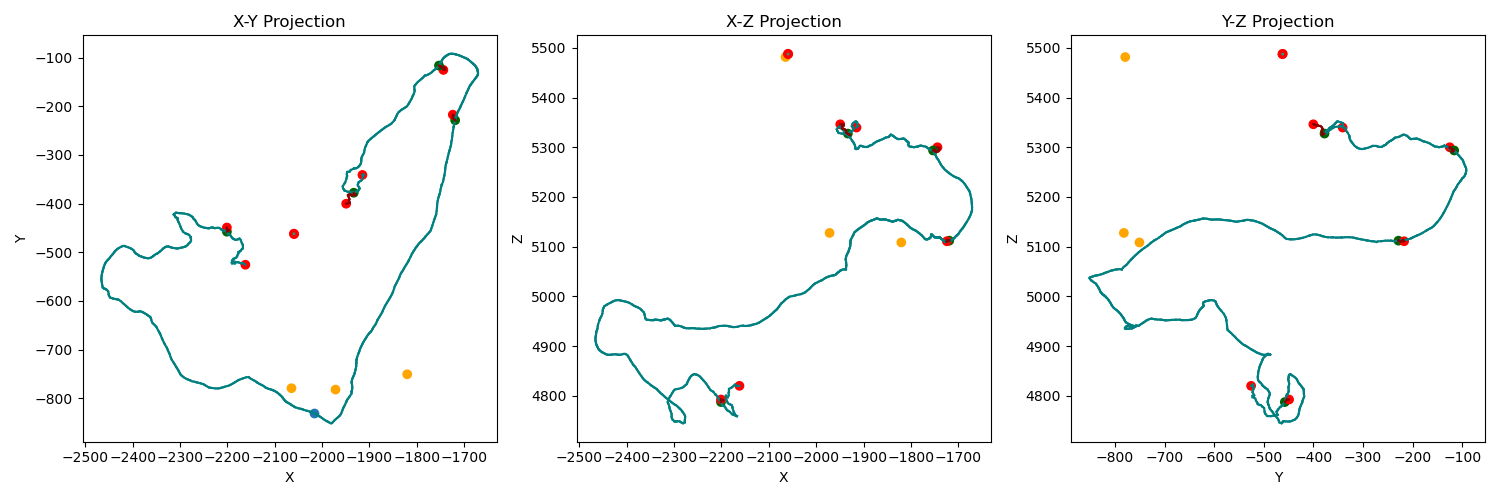

In [28]:
def RebuildTracks(connected_nodes_, connection_count_, data):

    RebuiltTrack_ = []
    Track_arrays = []
    Accounted_nodes = []
    track_nodes = []

    data_nodes = data.index.values.tolist()
    remaining_nodes = data_nodes
    trk_ids = 0
    i = 0
    
    # Loop over and build tracks
    while remaining_nodes:
        RebuildTracks_, remaining_nodes, trk_ids = MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, i, trk_ids, RebuiltTrack_)
        i = i + 1

    # Quality control
    track_nodes = []
    e_sum = 0
    for t in RebuiltTrack_:
        e_sum = e_sum+t["energy"]
        track_nodes = track_nodes + t["nodes"]


    ratio = e_sum / data.energy.sum()

    if (ratio < 0.999 or ratio > 1.0001):
        print("Ratio is off:", ratio)
        return RebuiltTrack_, False

    are_equal = set(track_nodes) == set(data_nodes)

    if (not are_equal):
        print("Missing Nodes:", set(data_nodes) - set(track_nodes))
        return RebuiltTrack_, False

    return RebuiltTrack_, True


def MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, iteration, trk_ids, RebuiltTrack_):

    Track_arrays = []

    prim_track_id = -1
    prim_len = 0
    prim_track_arr = []
    prim_energy = 0

    # Get all nodes with single connections
    end_points = np.where(connection_count_ == 1)[0]
    end_points = [x for x in end_points if x in remaining_nodes]

    if (iteration == 0):
        primary_label = "Primary"
        delta_label = "Delta"
        color = "Teal"
    else:
        primary_label = "Brem"
        delta_label = "BremDelta"
        color = next(color_cycle)

    for index, end_point in enumerate(end_points):
        trkpath = GetLongestPath(connected_nodes_, end_point)
        Track_arrays.append(trkpath)

        trk_length = GetTrackLength(trkpath, data)

        if (trk_length > prim_len):
            prim_len = trk_length
            prim_track_id = index
            prim_track_arr = trkpath
            prim_energy = GetTrackEnergy(trkpath, data, False)
    
    # Create the primary track
    RebuiltTrack_.append({"id":trk_ids, "start":prim_track_arr[0], "end":prim_track_arr[-1], "length":trk_length, "energy":prim_energy, "label":primary_label, "c":color, "nodes":prim_track_arr})
    trk_ids = trk_ids + 1

    # Get all nodes with three connections in the primary track
    multi_connections = np.where(connection_count_ == 3)[0]
    prim_track_multi_connections = [x for x in multi_connections if x in prim_track_arr]

    for node in prim_track_multi_connections:
        delta_node = [x for x in connected_nodes_[node] if x not in prim_track_arr]

        if (len(delta_node) > 1):
            print("Error the delta node has more than one node after cut")

        delta_paths = GetDeltaPath(connected_nodes_, node , delta_node[0], 0)
    
        for t in range(len(delta_paths)):
            trkpath = delta_paths[t]
            trk_energy = GetTrackEnergy(trkpath, data, True)
            trk_length = GetTrackLength(trkpath, data)
            RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":trk_length, "energy":trk_energy, "label":f"{delta_label}{t}", "c":"DarkRed", "nodes":trkpath})
            trk_ids = trk_ids + 1


    # This is for single nodes
    single_points = np.where(connection_count_ == 0)[0]
    single_points = [x for x in single_points if x in remaining_nodes] # Removes ones that have already been added

    for index, single_point in enumerate(single_points):
        trkpath = [single_point]
        energy = GetTrackEnergy(trkpath, data, False)
        RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":0, "energy":energy, "label":"Brem", "c":"Orange", "nodes":trkpath})
        trk_ids = trk_ids + 1


    track_nodes = []
    for t in RebuiltTrack_:
        track_nodes = track_nodes + t["nodes"]
    remaining_nodes = list(set(data_nodes) - set(track_nodes))

    return RebuiltTrack_, remaining_nodes, trk_ids



RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [21]:
# Re-Color the tracks
Tracks = CategorizeTracks(Tracks)


In [22]:
for c in connection_count:
    if (c>2):print(c)

3
3
3
3


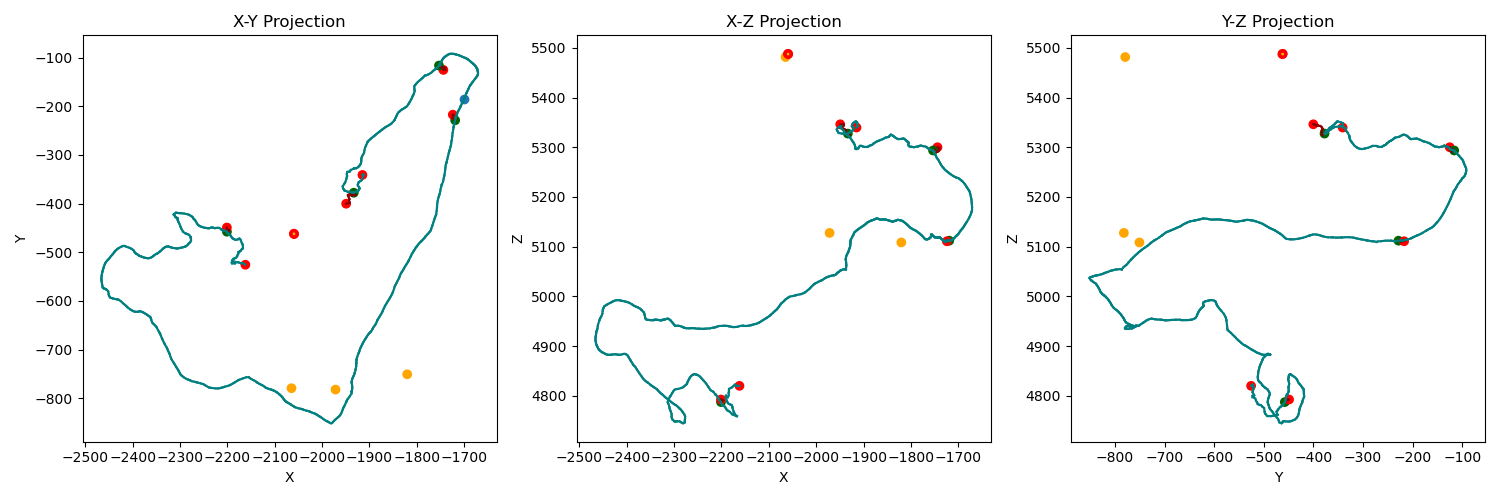

In [23]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

axs[0].scatter(data["x"].iloc[819], data["y"].iloc[819])

plt.tight_layout()
plt.show()

In [24]:
for i in connected_nodes:
    [print(connected_nodes[i])]

[1, 2]
[0, 3]
[4, 0]
[2, 5]
[1, 7]
[4, 6]
[5, 8]
[3, 9]
[10, 6]
[8, 12]
[11, 7]
[9, 13]
[14, 10]
[12, 15]
[11, 16]
[14, 17]
[15, 19]
[18, 13]
[16, 20]
[21, 17]
[19, 22]
[18, 24]
[21, 23]
[25, 22]
[23, 26]
[20, 30]
[25, 27]
[28, 26]
[27, 29]
[28, 31]
[33, 24]
[30, 38]
[32, 29]
[31, 34]
[33, 40]
[35, 32]
[34, 36]
[35, 37]
[36, 39]
[38, 44]
[37, 41]
[42, 39]
[41, 43]
[42, 45]
[47, 40]
[44, 52]
[43, 46]
[48, 45]
[46, 49]
[48, 50]
[49, 51]
[53, 50]
[51, 54]
[55, 47]
[52, 57]
[53, 56]
[54, 58]
[55, 60]
[59, 56]
[58, 61]
[59, 63]
[62, 57]
[60, 64]
[65, 61]
[63, 67]
[66, 62]
[64, 71]
[68, 65]
[67, 69]
[68, 70]
[69, 72]
[76, 66]
[71, 75]
[73, 70]
[72, 74]
[73, 77]
[76, 79]
[78, 74]
[77, 80]
[78, 81]
[85, 75]
[79, 96]
[83, 80]
[81, 84]
[86, 83]
[84, 94]
[85, 103]
[90, 87]
[88, 92]
[90, 95]
[93, 87]
[91, 97]
[92, 100]
[93, 99]
[98, 86]
[94, 101]
[97, 105]
[98, 106]
[95, 102]
[100, 104]
[96, 108]
[107, 102]
[104, 111]
[109, 99]
[105, 113]
[110, 101]
[106, 114]
[107, 115]
[112, 103]
[108, 119]
[109

In [25]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in Tracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in Tracks:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles[df_angles.trkID ==5])

print(connected_nodes)



The primary track is:  19


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
899,11304,-1929.629517,-382.753937,5324.755371,0.003750,638,0,5,6.855492,91.833883
900,11304,-1931.479248,-381.037476,5326.350586,0.005250,644,0,5,9.840866,166.099760
901,11304,-1933.116821,-381.250916,5326.745117,0.002750,643,0,5,11.538764,49.498361
902,11304,-1936.332031,-382.875305,5329.290039,0.006550,637,0,5,15.949302,27.937633
903,11304,-1937.473877,-383.123596,5332.655273,0.000475,635,0,5,19.511641,36.446084
904,11304,-1937.863892,-382.964478,5334.303711,0.001900,636,0,5,21.213045,10.820940
905,11304,-1939.955444,-381.434845,5336.263672,0.003550,641,0,5,24.462017,39.097332
906,11304,-1943.652344,-381.432434,5337.030273,0.001625,642,0,5,28.237563,41.137184
907,11304,-1945.414795,-382.179504,5338.544922,0.004550,639,0,5,30.678569,33.615436
908,11304,-1945.345581,-383.647766,5340.974609,0.011625,634,0,5,33.518281,47.813053


{0: [1, 2], 1: [0, 3], 2: [4, 0], 4: [2, 5], 3: [1, 7], 5: [4, 6], 6: [5, 8], 7: [3, 9], 8: [10, 6], 10: [8, 12], 9: [11, 7], 11: [9, 13], 12: [14, 10], 14: [12, 15], 13: [11, 16], 15: [14, 17], 17: [15, 19], 16: [18, 13], 18: [16, 20], 19: [21, 17], 21: [19, 22], 20: [18, 24], 22: [21, 23], 23: [25, 22], 25: [23, 26], 24: [20, 30], 26: [25, 27], 27: [28, 26], 28: [27, 29], 29: [28, 31], 30: [33, 24], 33: [30, 38], 31: [32, 29], 32: [31, 34], 38: [33, 40], 34: [35, 32], 35: [34, 36], 36: [35, 37], 37: [36, 39], 40: [38, 44], 39: [37, 41], 41: [42, 39], 42: [41, 43], 43: [42, 45], 44: [47, 40], 47: [44, 52], 45: [43, 46], 46: [48, 45], 48: [46, 49], 49: [48, 50], 50: [49, 51], 51: [53, 50], 53: [51, 54], 52: [55, 47], 55: [52, 57], 54: [53, 56], 56: [54, 58], 57: [55, 60], 58: [59, 56], 59: [58, 61], 61: [59, 63], 60: [62, 57], 62: [60, 64], 63: [65, 61], 65: [63, 67], 64: [66, 62], 66: [64, 71], 67: [68, 65], 68: [67, 69], 69: [68, 70], 70: [69, 72], 71: [76, 66], 76: [71, 75], 72: [73

Text(0, 0.5, 'Scatter Angle [deg]')

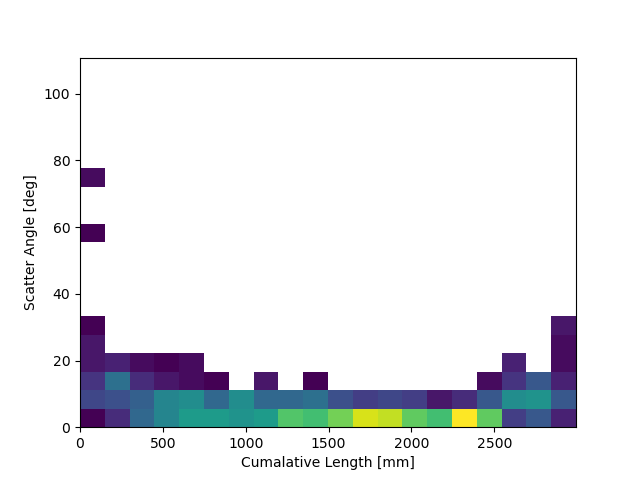

In [26]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

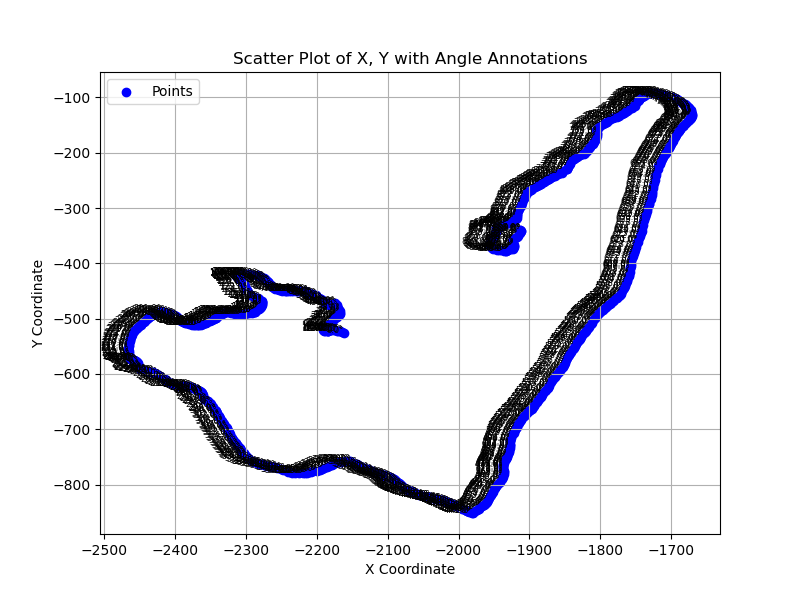

In [27]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()